<a href="https://colab.research.google.com/github/rahiakela/probabilistic-programming-practice/blob/main/bayesian-analysis-with-python/2-programming-probabilistically/1_pymc3_primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PyMC3 primer

PyMC3 is a Python library for probabilistic programming.It provides a very simple and intuitive syntax that is easy to read and that is close to the syntax used in the statistical literature to describe probabilistic models.

##Setup

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
az.style.use('arviz-darkgrid')

##Flipping coins the PyMC3 way

Let's revisit the coin-flipping problem, but this time using PyMC3. We will use the same synthetic data.Since we are generating the data, we know the true value of $\theta$.

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35   # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

##Model specification

Now that we have the data, we need to specify the model. Remember that this is done by specifying the likelihood and the prior using probability distributions. For the likelihood, we will use the binomial distribution with $n=1$ and $p=\theta$,and for the prior, a beta distribution with the parameters $\alpha=\beta=1$.

A beta distribution with such parameters is equivalent to a uniform distribution in the interval `[0, 1]`.

$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bern(p=\theta)$$

This statistical model has an almost one-to-one translation to PyMC3:

In [4]:
with pm.Model() as model:
  # a priori
  θ = pm.Beta("θ", alpha=1., beta=.1)
  # likelihood
  y = pm.Bernoulli("y", p=θ, observed=data)
  trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


The first and second lines tell us that PyMC3 has automatically assigned the NUTS sampler (one inference engine that works very well for continuous variables), and has used a method to initialize that sampler. The third line says that PyMC3 will run two chains in parallel, thus we will get two independent samples from the posterior for the price of one.

##Summarizing the posterior

Generally, the first task we will perform after sampling from the posterior is check what the results look like. 

The `plot_trace` function from ArviZ is ideally suited to this task:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61846e5f50>,
      dtype=object)

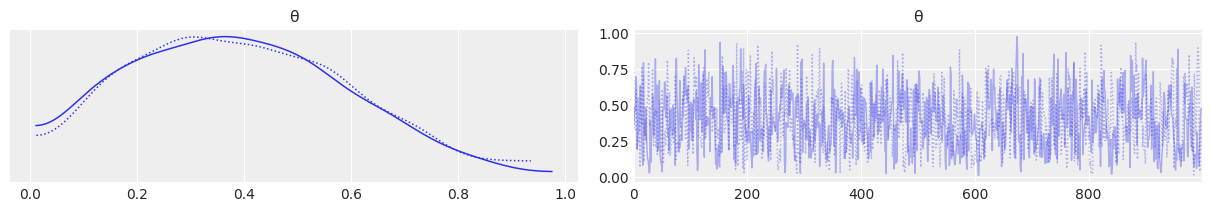

In [5]:
az.plot_trace(trace)

We get two subplots for each unobserved variable. The only unobserved variable in our model is $\theta$ . Notice that y is an observed variable representing
the data; we do not need to sample that because we already know those values.

On the left, we have a Kernel Density Estimation (KDE)
plot; this is like the smooth version of the histogram. On the right, we get the individual
sampled values at each step during the sampling. From the trace plot, we can visually get
the plausible values from the posterior.

We may also want to have a numerical summary of the trace. We can get
that using az.summary, which will return a pandas DataFrame:

In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.391,0.197,0.063,0.756,0.007,0.005,841.0,1194.0,1.0


Another way to visually summarize the posterior is to use the `plot_posterior` function that comes with ArviZ.

We are going to use it now for a real posterior. By default, plot_posterior
shows a histogram for discrete variables and KDEs for continuous variables.

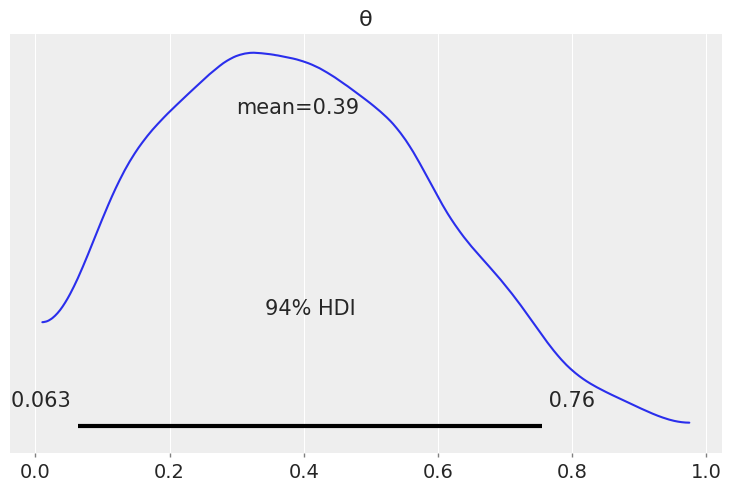

In [7]:
az.plot_posterior(trace)

##Posterior-based decisions

Sometimes, describing the posterior is not enough. Sometimes, we need to make decisions
based on our inferences. We have to reduce a continuous estimation to a dichotomous one:
yes-no, health-sick, contaminated-safe, and so on.

###ROPE

For example, we could say that any
value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. We
call this interval a Region Of Practical Equivalence (ROPE). Once the ROPE is defined, we
compare it against the Highest-Posterior Density (HPD). 

We can get at least three
scenarios:

- The ROPE does not overlap with the HPD; we can say the coin is not fair
- The ROPE contains the entire HPD; we can say the coin is fair
- The ROPE partially overlaps with HPD; we cannot say the coin is fair or unfair

Decisions are inherently subjective and our mission is to take the most informed possible decisions according to our goals.

We can use the plot_posterior function to plot the posterior with the HPD interval and
the ROPE. The ROPE appears as a semi-transparent thick (green) line:

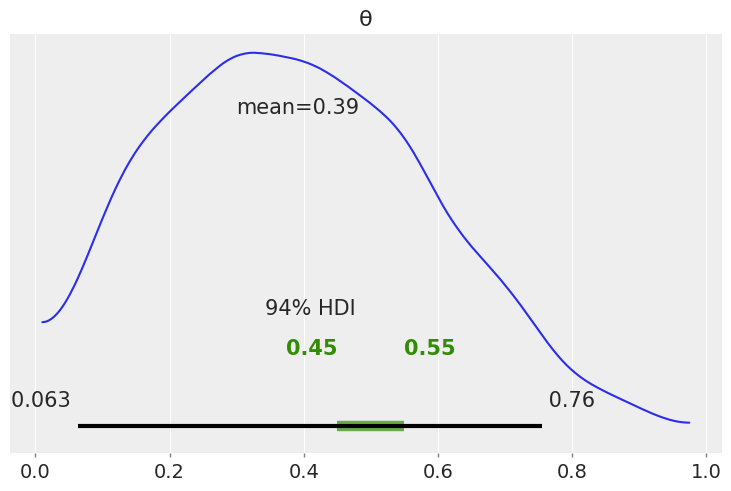

In [8]:
az.plot_posterior(trace, rope=[0.45, .55])

Another tool we can use to help us make a decision is to compare the posterior against a
reference value. We can do this using plot_posterior. 

As you can see, we get a vertical
(orange) line and the proportion of the posterior above and below our reference value:

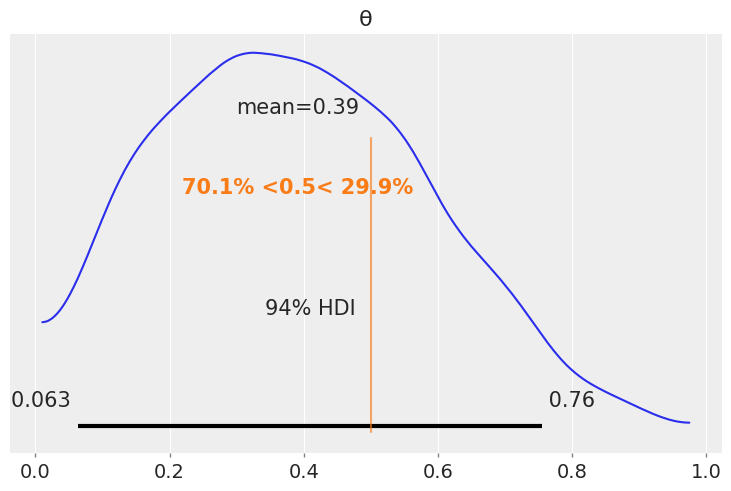

In [9]:
az.plot_posterior(trace, ref_val=0.5)

##Loss functions

The cost/benefit trade-off can be mathematically formalized using loss functions.
The names for loss functions or its inverses vary across different fields, and we could find
names such as cost functions, objective functions, fitness functions, utility functions, and so
on. No matter the name, the key idea is to use a function that captures how different the
true value and the estimated value of a parameter are. The larger the value of the loss
function, the worse the estimation is (according to the loss function). 

Some common examples of loss functions are:

1. The quadratic loss $(\theta - \hat\theta)^2$
2. The absolute loss $|\theta - \hat\theta|$
3. The 0-1 loss $I(\theta \neq \hat\theta)$

In practice, we generally do not have the value of the true parameter $\theta$ at hand. Instead, we
have an estimation in the form of a posterior distribution. Thus, what we can do is find out
the value of $\hat\theta$ that minimizes the expected loss function. By expected loss function, we
mean the loss function averaged over the whole posterior distribution.

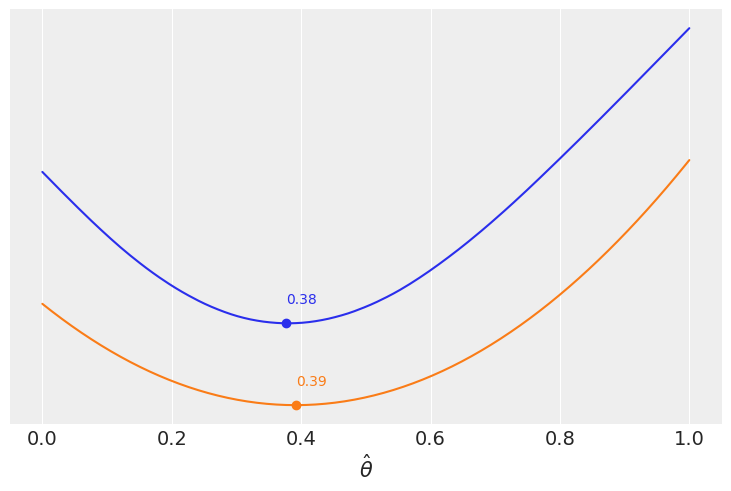

In [10]:
# a value of θ over a grid of 200 points
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']

# we have two loss functions: the absolute loss and and the quadratic loss
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
  # include the value of θ that minimizes each loss function
  mini = np.argmin(lossf)
  plt.plot(grid, lossf, c)
  plt.plot(grid[mini], lossf[mini], 'o', color=c)
  plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
  plt.yticks([])
  plt.xlabel(r'$\hat \theta$')

In [11]:
np.mean(θ_pos), np.median(θ_pos)

(0.391350786571939, 0.37910104087471985)

OK, so if we want to be formal and we want to compute a single point-estimate, we must
decide which loss function we want, or in reverse, if we choose a given point-estimate, we
are implicitly (and maybe even unconsciously) deciding on a loss function. 

The advantage
of explicitly choosing a loss function is that we can tailor the function to our problem,
instead of using some predefined rule that may not be suitable in our particular case.

For
example, in many problems, the cost of making a decision is asymmetric; it is not the same
to decide whether it is safe or not to administrate a vaccine to children under five and being
right, that being wrong. Making a bad decision could cost thousands of lives and produce a
health crisis that could have being avoided by administrating a cheap and safe vaccine.
Thus, if our problem demands it, we can construct an asymmetric loss function. It also
important to notice that, as the posterior is in the form of numerical samples, we can
compute complex loss functions that don't need to be restricted by mathematical
convenience or mere simplicity.

The following is just a silly example of this:

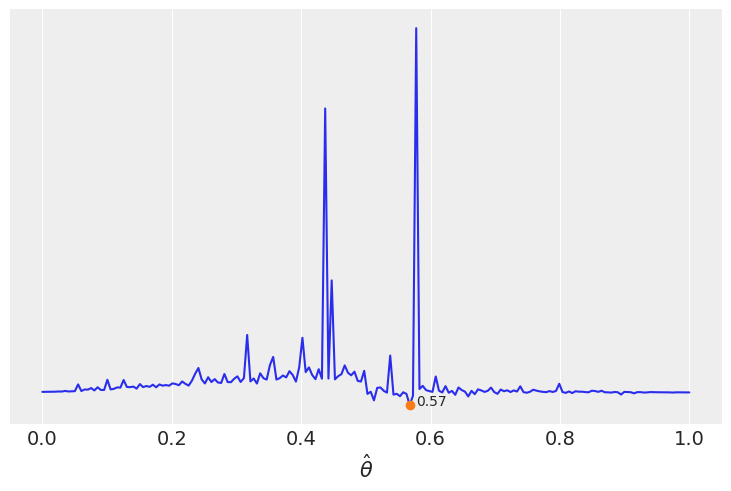

In [13]:
lossf = []
for i in grid:
  if i < 0.5:
      f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
  else:
      f = np.mean(1 / (i - θ_pos))
  lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

It is not true that every time people uses a
point-estimate they are truly thinking in terms of loss functions. In fact, loss functions are
not very common in many of the scientific fields I am more or less familiar with. 

People
often choose the median, just because it is more robust to outliers than the mean, or use the
mean just because is a simple and familiar concept, or because they think their observable is
truly the average of some process at some level, like molecules bouncing to each other or
genes interacting with themselves and the environment.